In [33]:
import numpy as np
import gym
import random
import imageio
import os

import pickle5 as pickle
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
# # Virtual display
# from pyvirtualdisplay import Display

# virtual_display = Display(visible=0, size=(1400, 900))
# virtual_display.start()

In [3]:
env = gym.make('FrozenLake-v1', map_name='4x4', is_slippery=False)

In [4]:
env.observation_space

Discrete(16)

In [5]:
env.observation_space.sample()

8

In [6]:
env.action_space

Discrete(4)

In [7]:
env.action_space.sample()

1

In [8]:
state_space = env.observation_space.n
action_space = env.action_space.n

In [9]:
def initialize_Qtable(state_space, action_space):
    Qtable = np.zeros((state_space, action_space))
    return Qtable

In [10]:
Qtable_frozenlake = initialize_Qtable(state_space, action_space)
Qtable_frozenlake

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [11]:
rng = np.random.default_rng(23)

In [12]:
def greedy_policy(Qtable, state):
    return np.argmax(Qtable[state])

In [13]:
def epsilon_greedy_policy(Qtable, state, epsilon):
    if rng.uniform() > epsilon:
        return greedy_policy(Qtable, state) 
    return env.action_space.sample() 

In [130]:
n_training_episodes = 1_000_000
learning_rate = 0.4

n_eval_episodes = 1000

env_id = 'FrozenLake-v1'
max_steps = 999
gamma = 0.98
eval_seed = []

max_epsilon = 1.0
min_epsilon = 5e-2
decay_rate = 5 / n_training_episodes

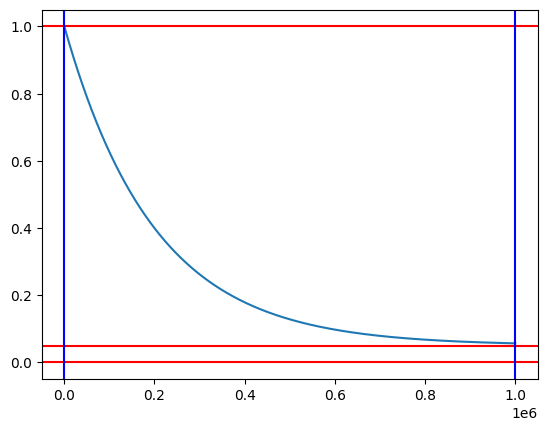

In [117]:
import matplotlib.pyplot as plt
xs = np.arange(n_training_episodes)
ys = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * xs )
plt.plot(xs, ys)
plt.axhline(y=max_epsilon, color='r', linestyle='-')
plt.axhline(y=min_epsilon, color='r', linestyle='-')
plt.axhline(y=0, color='r', linestyle='-')
plt.axvline(x=0, color='b', linestyle='-')
plt.axvline(x=n_training_episodes, color='b', linestyle='-')

In [32]:
def train(env, n_training_episodes, max_step, min_epsilon, max_epsilon, decay_rate, Qtable):
    for episode in tqdm(range(n_training_episodes)):
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
        state = env.reset()
        done = False
        for step in range(max_steps):
            action = epsilon_greedy_policy(Qtable, state, epsilon)
            new_state, reward, done, info = env.step(action)
            Qtable[state][action] = Qtable[state][action] + learning_rate * (
                reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action]
            )
            if done:
                break
            state = new_state
    return Qtable

In [17]:
Qtable_frozenlake = train(env, n_training_episodes, max_steps, min_epsilon, max_epsilon, decay_rate, Qtable_frozenlake)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [18]:
Qtable_frozenlake

array([[0.94148015, 0.95099005, 0.95099005, 0.94148015],
       [0.94148015, 0.        , 0.96059601, 0.95099005],
       [0.95099005, 0.970299  , 0.95099005, 0.96059601],
       [0.96059601, 0.        , 0.95099005, 0.95099005],
       [0.95099005, 0.96059601, 0.        , 0.94148015],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9801    , 0.        , 0.96059601],
       [0.        , 0.        , 0.        , 0.        ],
       [0.96059601, 0.        , 0.970299  , 0.95099005],
       [0.96059601, 0.9801    , 0.9801    , 0.        ],
       [0.970299  , 0.99      , 0.        , 0.970299  ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9801    , 0.99      , 0.970299  ],
       [0.9801    , 0.99      , 1.        , 0.9801    ],
       [0.        , 0.        , 0.        , 0.        ]])

In [19]:
def trace_path(Qtable):
    n_rows = 4; row = 0; col = 0
    state = 0 
    print(state)
    while state != 15:
        action = np.argmax(Qtable[state])
        match action:
            case 0:
                col -= 1
            case 1:
                row += 1
            case 2:
                col += 1
            case _:
                row -= 1
        state = row * n_rows + col
        print(state)

In [20]:
trace_path(Qtable_frozenlake)

0
4
8
9
13
14
15


In [21]:
def evaluate_agent(env, n_eval_episodes, max_steps, Qtable, seed):
    episode_rewards = []
    for episode in tqdm(range(n_eval_episodes)):
        if seed:
            state = env.reset(seed=seed[episode])
        else:
            state = env.reset()
        total_rewards_ep = 0
        done = False
        for step in range(max_steps):
            action = greedy_policy(Qtable, state)
            new_state, reward, done, info = env.step(action)
            total_rewards_ep += reward 
            if done:
                break
            state = new_state
        episode_rewards.append(total_rewards_ep)
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    return mean_reward, std_reward

In [22]:
# Evaluate our Agent
mean_reward, std_reward = evaluate_agent(env, n_eval_episodes, max_steps, Qtable_frozenlake, eval_seed)
print(f"Mean Reward = {mean_reward:.2f} +/- {std_reward:.2f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Mean Reward = 1.00 +/- 0.00


In [35]:
from huggingface_hub import HfApi, snapshot_download
from huggingface_hub.repocard import metadata_eval_result, metadata_save

from pathlib import Path
import datetime
import json

In [97]:
def record_video(env, Qtable, out_directory, fps=1):
    """
    Generate a replay video of the agent
    :param env
    :param Qtable: Qtable of our agent
    :param out_directory
    :param fps: how many frame per seconds (with taxi-v3 and frozenlake-v1 we use 1)
    """
    images = []
    state = env.reset(seed=random.randint(0, 500))
    img = env.render(mode="rgb_array")
    images.append(img)
    done = False
    while not done:
        # Take the action (index) that have the maximum expected future reward given that state
        action = greedy_policy(Qtable, state)
        state, reward, done, info = env.step(action)  # We directly put next_state = state for recording logic
        img = env.render(mode="rgb_array")
        images.append(img)
    imageio.mimwrite(out_directory, images, fps=fps)

record_video(env, Qtable_frozenlake, './out/frozenlake.mp4')

In [46]:
def push_to_hub(repo_id, model, env, video_fps=1, local_repo_path="hub"):
    """
    Evaluate, Generate a video and Upload a model to Hugging Face Hub.
    This method does the complete pipeline:
    - It evaluates the model
    - It generates the model card
    - It generates a replay video of the agent
    - It pushes everything to the Hub

    :param repo_id: repo_id: id of the model repository from the Hugging Face Hub
    :param env
    :param video_fps: how many frame per seconds to record our video replay
    (with taxi-v3 and frozenlake-v1 we use 1)
    :param local_repo_path: where the local repository is
    """
    _, repo_name = repo_id.split("/")

    eval_env = env
    api = HfApi()

    # Step 1: Create the repo
    repo_url = api.create_repo(
        repo_id=repo_id,
        exist_ok=True,
    )

    # Step 2: Download files
    repo_local_path = Path(snapshot_download(repo_id=repo_id))

    # Step 3: Save the model
    if env.spec.kwargs.get("map_name"):
        model["map_name"] = env.spec.kwargs.get("map_name")
        if env.spec.kwargs.get("is_slippery", "") == False:
            model["slippery"] = False

    # Pickle the model
    with open((repo_local_path) / "q-learning.pkl", "wb") as f:
        pickle.dump(model, f)

    # Step 4: Evaluate the model and build JSON with evaluation metrics
    mean_reward, std_reward = evaluate_agent(
        eval_env, model["max_steps"], model["n_eval_episodes"], model["qtable"], model["eval_seed"]
    )

    evaluate_data = {
        "env_id": model["env_id"],
        "mean_reward": mean_reward,
        "n_eval_episodes": model["n_eval_episodes"],
        "eval_datetime": datetime.datetime.now().isoformat(),
    }

    # Write a JSON file called "results.json" that will contain the
    # evaluation results
    with open(repo_local_path / "results.json", "w") as outfile:
        json.dump(evaluate_data, outfile)

    # Step 5: Create the model card
    env_name = model["env_id"]
    if env.spec.kwargs.get("map_name"):
        env_name += "-" + env.spec.kwargs.get("map_name")

    if env.spec.kwargs.get("is_slippery", "") == False:
        env_name += "-" + "no_slippery"

    metadata = {}
    metadata["tags"] = [env_name, "q-learning", "reinforcement-learning", "custom-implementation"]

    # Add metrics
    eval = metadata_eval_result(
        model_pretty_name=repo_name,
        task_pretty_name="reinforcement-learning",
        task_id="reinforcement-learning",
        metrics_pretty_name="mean_reward",
        metrics_id="mean_reward",
        metrics_value=f"{mean_reward:.2f} +/- {std_reward:.2f}",
        dataset_pretty_name=env_name,
        dataset_id=env_name,
    )

    # Merges both dictionaries
    metadata = {**metadata, **eval}

    model_card = f"""
    # **Q-Learning** Agent playing1 **{env_id}**
    This is a trained model of a **Q-Learning** agent playing **{env_id}** .

    ## Usage

    ```python

    model = load_from_hub(repo_id="{repo_id}", filename="q-learning.pkl")

    # Don't forget to check if you need to add additional attributes (is_slippery=False etc)
    env = gym.make(model["env_id"])
    ```
    """

    evaluate_agent(env, model["max_steps"], model["n_eval_episodes"], model["qtable"], model["eval_seed"])

    readme_path = repo_local_path / "README.md"
    readme = ""
    print(readme_path.exists())
    if readme_path.exists():
        with readme_path.open("r", encoding="utf8") as f:
            readme = f.read()
    else:
        readme = model_card

    with readme_path.open("w", encoding="utf-8") as f:
        f.write(readme)

    # Save our metrics to Readme metadata
    metadata_save(readme_path, metadata)

    # Step 6: Record a video
    video_path = repo_local_path / "replay.mp4"
    record_video(env, model["qtable"], video_path, video_fps)

    # Step 7. Push everything to the Hub
    api.upload_folder(
        repo_id=repo_id,
        folder_path=repo_local_path,
        path_in_repo=".",
    )

    print("Your model is pushed to the Hub. You can view your model here: ", repo_url)

In [47]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved to /home/rayed/.huggingface/token
Login successful


In [48]:
model = {
    "env_id": env_id,
    "max_steps": max_steps,
    "n_training_episodes": n_training_episodes,
    "n_eval_episodes": n_eval_episodes,
    "eval_seed": eval_seed,
    "learning_rate": learning_rate,
    "gamma": gamma,
    "max_epsilon": max_epsilon,
    "min_epsilon": min_epsilon,
    "decay_rate": decay_rate,
    "qtable": Qtable_frozenlake,
}

In [49]:
model

{'env_id': 'FrozenLake-v1',
 'max_steps': 99,
 'n_training_episodes': 100000,
 'n_eval_episodes': 100,
 'eval_seed': [],
 'learning_rate': 0.7,
 'gamma': 0.99,
 'max_epsilon': 1.0,
 'min_epsilon': 0.05,
 'decay_rate': 5e-05,
 'qtable': array([[0.94148015, 0.95099005, 0.95099005, 0.94148015],
        [0.94148015, 0.        , 0.96059601, 0.95099005],
        [0.95099005, 0.970299  , 0.95099005, 0.96059601],
        [0.96059601, 0.        , 0.95099005, 0.95099005],
        [0.95099005, 0.96059601, 0.        , 0.94148015],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.9801    , 0.        , 0.96059601],
        [0.        , 0.        , 0.        , 0.        ],
        [0.96059601, 0.        , 0.970299  , 0.95099005],
        [0.96059601, 0.9801    , 0.9801    , 0.        ],
        [0.970299  , 0.99      , 0.        , 0.970299  ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.

In [50]:
username = "rayedbw"  # FILL THIS
repo_name = "q-FrozenLake-v1-4x4-noSlippery"
push_to_hub(repo_id=f"{username}/{repo_name}", model=model, env=env)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

False
Your model is pushed to the Hub. You can view your model here:  https://huggingface.co/rayedbw/q-FrozenLake-v1-4x4-noSlippery


In [65]:
from gym.envs.toy_text.frozen_lake import generate_random_map

random_map = gym.make('FrozenLake-v1', desc=generate_random_map(size=4), is_slippery=False)

In [66]:
record_video(random_map, Qtable_frozenlake, './out/random_map.mp4')

In [58]:
desc=["FFFS", "FHFH", "FFFH", "HFFG"]

In [61]:
different_start = gym.make('FrozenLake-v1', desc=desc, is_slippery=False)
record_video(different_start, Qtable_frozenlake, './out/different_start.mp4')

In [60]:
Qtable_frozenlake

array([[0.94148015, 0.95099005, 0.95099005, 0.94148015],
       [0.94148015, 0.        , 0.96059601, 0.95099005],
       [0.95099005, 0.970299  , 0.95099005, 0.96059601],
       [0.96059601, 0.        , 0.95099005, 0.95099005],
       [0.95099005, 0.96059601, 0.        , 0.94148015],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9801    , 0.        , 0.96059601],
       [0.        , 0.        , 0.        , 0.        ],
       [0.96059601, 0.        , 0.970299  , 0.95099005],
       [0.96059601, 0.9801    , 0.9801    , 0.        ],
       [0.970299  , 0.99      , 0.        , 0.970299  ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9801    , 0.99      , 0.970299  ],
       [0.9801    , 0.99      , 1.        , 0.9801    ],
       [0.        , 0.        , 0.        , 0.        ]])

In [131]:
slippery_env = gym.make('FrozenLake-v1', map_name='4x4', is_slippery=True)

In [132]:
Qtable_frozenlake_slippery = initialize_Qtable(state_space, action_space)
Qtable_frozenlake_slippery = train(slippery_env, n_training_episodes, max_steps, min_epsilon, max_epsilon, decay_rate, Qtable_frozenlake_slippery)
Qtable_frozenlake_slippery

  0%|          | 0/1000000 [00:00<?, ?it/s]

array([[0.38551951, 0.33677242, 0.34773546, 0.3590971 ],
       [0.20627795, 0.07545531, 0.16420321, 0.31833276],
       [0.18870198, 0.16857081, 0.16527697, 0.23103361],
       [0.16592751, 0.10662416, 0.13027802, 0.18728589],
       [0.41252113, 0.17875088, 0.23962946, 0.29747266],
       [0.        , 0.        , 0.        , 0.        ],
       [0.02341261, 0.02611703, 0.3212266 , 0.00505443],
       [0.        , 0.        , 0.        , 0.        ],
       [0.33030394, 0.04589369, 0.32601253, 0.44045182],
       [0.11023475, 0.50131831, 0.32083328, 0.25955107],
       [0.09665826, 0.37065965, 0.07687022, 0.0730113 ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.43081886, 0.25944466, 0.69403743, 0.17881021],
       [0.59295048, 0.97167485, 0.68569687, 0.57777737],
       [0.        , 0.        , 0.        , 0.        ]])

In [133]:
evaluate_agent(slippery_env, n_eval_episodes, max_steps, Qtable_frozenlake_slippery, seed=[])

  0%|          | 0/1000 [00:00<?, ?it/s]

(0.604, 0.48906441293555597)

In [134]:
record_video(slippery_env, Qtable_frozenlake_slippery, './out/frozenlake_slippery.mp4')

In [135]:
model = {
    "env_id": env_id,
    "max_steps": max_steps,
    "n_training_episodes": n_training_episodes,
    "n_eval_episodes": n_eval_episodes,
    "eval_seed": eval_seed,
    "learning_rate": learning_rate,
    "gamma": gamma,
    "max_epsilon": max_epsilon,
    "min_epsilon": min_epsilon,
    "decay_rate": decay_rate,
    "qtable": Qtable_frozenlake_slippery,
}

In [136]:
username = "rayedbw"  # FILL THIS
repo_name = "q-FrozenLake-v1-4x4-isSlippery"
push_to_hub(repo_id=f"{username}/{repo_name}", model=model, env=slippery_env)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/834 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/38.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134 [00:00<?, ?B/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

True
Your model is pushed to the Hub. You can view your model here:  https://huggingface.co/rayedbw/q-FrozenLake-v1-4x4-isSlippery


In [124]:
slippery_env.spec.kwargs

{'map_name': '4x4', 'is_slippery': True}